In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# torch.manual_seed(1)

In [2]:
# 超参数设置
EPOCH = 5
LR = 0.001
DOWNLOAD_MNIST = False


# 制作训练集、测试集
train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(), download=False)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=torchvision.transforms.ToTensor(), download=False)
print("train_data.shape:", train_data.data.shape)
print("test_data.shape:", test_data.data.shape)

# 对训练数据进行预处理
train_x = torch.unsqueeze(train_data.data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.targets
print("train_x.shape:", train_x.shape)
print("train_y.shape:", train_y.shape)

# 对测试数据进行预处理
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000] / 255.  # Tensor on GPU
test_y = test_data.targets[:2000]
print("test_x.shape:", test_x.shape)
print("test_y.shape:", test_y.shape)

train_data.shape: torch.Size([60000, 28, 28])
test_data.shape: torch.Size([10000, 28, 28])
train_x.shape: torch.Size([60000, 1, 28, 28])
train_y.shape: torch.Size([60000])
test_x.shape: torch.Size([2000, 1, 28, 28])
test_y.shape: torch.Size([2000])


In [3]:
def train(net, train_x, train_y, test_x, test_y, EPOCH, optimizer, loss_func):
    prev_time = datetime.now()	# begin time

    data_size = 20000
    batch_size = 32

    for epoch in range(EPOCH):
        train_loss, train_acc = 0, 0
        net.train() # train
        random_indx = np.random.permutation(data_size)
        for batch_i in range(data_size // batch_size):
            indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

            b_x = train_x[indx, :]
            b_y = train_y[indx]

            output = net(b_x)
            loss = loss_func(output, b_y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
             
            if batch_i % 50 == 0:
                net.eval()	# eval
                test_output = net(test_x)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)

                train_losses.append(loss.data.cpu().numpy())	# save for visualization
                test_acces.append(accuracy)	# save for visualization
                
        scheduler.step()  # update lr
        
        cur_time = datetime.now()	# end time
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "%02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time

        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.3f' % accuracy,  '| time: ',time_str)

In [4]:
def conv3x3(in_channel, out_channel, stride=1):
    return nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)


class residual_block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(residual_block, self).__init__()
        stride = 1
        self.conv1 = conv3x3(in_channel, out_channel, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channel)	# batchnorm
        self.dp1 = nn.Dropout(0.05)	# dropout
        self.conv2 = conv3x3(out_channel, out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.dp2 = nn.Dropout(0.05)
        self.conv3 = nn.Conv2d(in_channel, out_channel, 1, stride=stride)
        
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.dp1(out)      
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        out = self.dp2(out)        
        x = self.conv3(x)
        return F.relu(x + out)
    
    
# 构建resnet网络结构
class resnet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(resnet, self).__init__()
        
        # [b,1,28,28] -> [b,16,24,24]
        self.block1 = nn.Conv2d(in_channel, 16, 5)
      
    	# [b,16,24,24] -> [b,16,12,12] -> [b,16,12,12]
        self.block2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            residual_block(16, 16)          
        )
   		
        # [b,16,12,12] -> [b,32,8,8]
        self.block3 = nn.Conv2d(16, 32, 5)
        
        # [b,32,8,8] -> [b,32,4,4] -> [b,32,4,4]
        self.block4 = nn.Sequential(
            residual_block(32, 32),
            nn.AvgPool2d(2)
        )
        
        # [b,32,4,4] -> [b,10]
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    
net = resnet(1, 10)
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=1e-4)	# regularization
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1), last_epoch=-1)	# lr_dacay
loss_func = nn.CrossEntropyLoss()

train_losses, test_acces = [], []

In [5]:
train(net, train_x, train_y, test_x, test_y, EPOCH, optimizer, loss_func)

Epoch:  0 | train loss: 0.0539 | test accuracy: 0.952 | time:  00:00:56
Epoch:  1 | train loss: 0.3075 | test accuracy: 0.966 | time:  00:01:00
Epoch:  2 | train loss: 0.0183 | test accuracy: 0.982 | time:  00:00:59
Epoch:  3 | train loss: 0.0254 | test accuracy: 0.979 | time:  00:00:59
Epoch:  4 | train loss: 0.0233 | test accuracy: 0.980 | time:  00:00:59


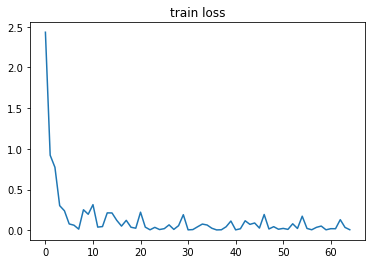

In [6]:
plt.title('train loss')
plt.plot(np.arange(len(train_losses)), train_losses)

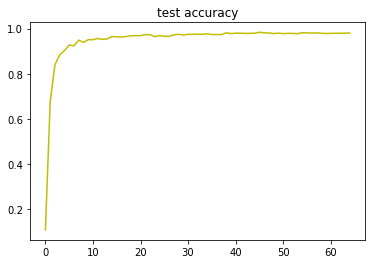

In [7]:
plt.title('test accuracy')
plt.plot(np.arange(len(test_acces)), test_acces, 'y')

In [8]:
print("Accuracy for test_data:", test_acces[-1].numpy())

Accuracy for test_data: 0.984


prediction number: 7
real number: [7]


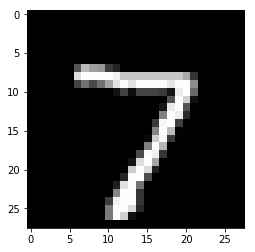

prediction number: 2
real number: [2]


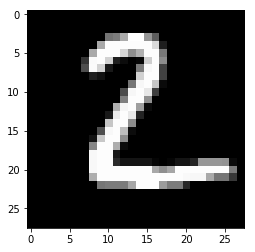

prediction number: 1
real number: [1]


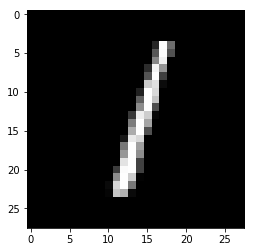

prediction number: 0
real number: [0]


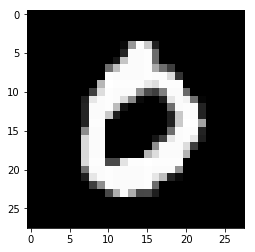

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


for i in range(10):
    test_output = net(test_x[i:i+1])
    pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU
    
    plt.ion()
    plt.imshow(test_x[i:i+1].numpy().squeeze(), 'gray')
    print('prediction number:', pred_y.numpy())  
    print('real number:', test_y[i:i+1].numpy())
    plt.pause(1)
    plt.close()
  